In [13]:
%pylab inline
#%config InlineBackend.figure_format = 'retina' 

Populating the interactive namespace from numpy and matplotlib


In [14]:
#here are some common modules:
import scipy as sp #library of scientific functions
import scipy.io 
import scipy.signal as signal
import numpy as np #library of math functions
import pandas as pd #library of data analysis functions
import matplotlib.pyplot as plt #functions to plot data
import os #This lets python talk to your opperating system to open and save files.
from parabolic import parabolic

In [15]:
filename = 'emodat.mat' #adjut file name here
filename = os.path.join('../FM-BCI', filename) #adjust filepath 
datafile = sp.io.loadmat(filename) #loading filename
#print datafile.keys()
voltageSamples = datafile['data'] 
#print voltageSamples.shape, len(voltageSamples)

In [16]:
variances = []
means = []
medians = []
standardDeviations = []
for i in range(len(voltageSamples)):
    variances.append(np.var(voltageSamples[i,:]))
    means.append(np.mean(voltageSamples[i,:]))
    medians.append(np.median(voltageSamples[i,:]))
    standardDeviations.append(np.std(voltageSamples[i,:]))

In [17]:
for i in range(len(voltageSamples)):
    print 'Channel', i+1
    print '\tmean:', means[i]
    print '\tmedian:', medians[i]
    print '\tstandard deviation:', standardDeviations[i]
    print '\tvariance:', np.var(voltageSamples)

Channel 1
	mean: 53.5051604742
	median: 8.42684103561
	standard deviation: 105.317167517
	variance: 11091.7057739


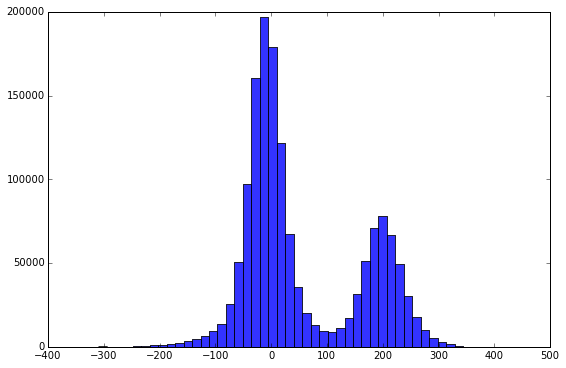

In [18]:
fig1 = plt.figure(1, figsize=(9,6))
numBins = 50
n, bins, patches = plt.hist(voltageSamples[0],numBins,alpha=0.8)


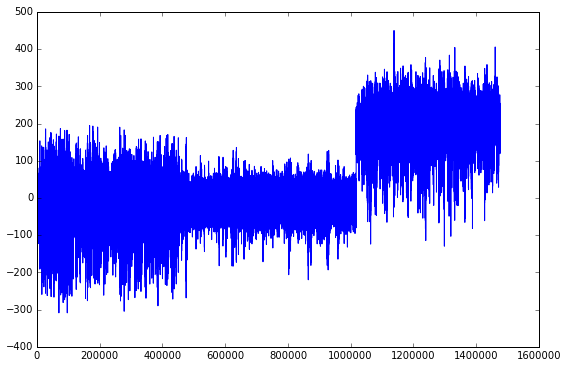

In [19]:
fig2 = plt.figure(2, figsize=(9,6))
plt.plot(voltageSamples[0])

Channel weights: 

         1     1.0
         2     0.875
         3     0.75
         4     0.625
         5     0.5
         6     0.375
         7     0.25
         8     0.125


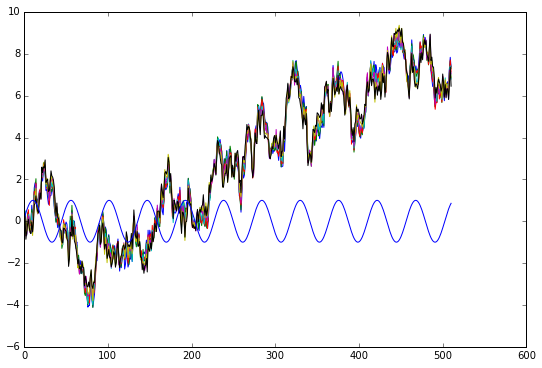

In [40]:
sampleRate = 512 # sample rate assumed during recording
sampleSpacing = 1.0 / sampleRate # time between samples in seconds
dataLengthSecs = 60 # length of whole recording
dataLengthSamples = dataLengthSecs*sampleRate # length of whole recording in samples

t = np.arange(0,dataLengthSecs,sampleSpacing) # time vector spanning length in seconds, with approp. num of samples
#numOfChannel = voltageSamples.shape[0] # determine number of channels from data, i.e. not predefined
numOfChannel = 8
voltageSamples = np.empty([numOfChannel, dataLengthSamples])

# channel weighting
channelWeights = np.linspace(1,1./numOfChannel,numOfChannel) 
#np.random.shuffle(channelWeights)
print 'Channel weights:', '\n'
for channelIndex in range(numOfChannel):
    print "        ", channelIndex+1, "   ", channelWeights[channelIndex]
    
# frequency modulation parameters
alphaCenter = 10.25   # Hz the carrier frequency
alphaModFreq = 0.1  # Hz the modulating frequency
alphaFreqDev = 1    # Hz of the frequency deviation

# signal to noise parameters
snr = 2             # signal / noise
noiseMean = 0
noiseStdDev = 0.5
alphaMean = 0
alphaStdDev = abs(np.sqrt(snr*(noiseStdDev**2))) # std of sine wave
alphaAmp = np.sqrt(2)*alphaStdDev
h = alphaFreqDev/alphaModFreq         # Modulation index

# Constructs 1/f noise by iteratively adding normal random noise, effectively the CDF of normal dist.
normalNoise = np.random.normal(noiseMean, noiseStdDev, (1,dataLengthSamples))
pinkNoise = np.cumsum(normalNoise)

# Frequency modulated alpha rhythm, a sinusoidal baseband signal
alpha = alphaAmp*np.sin( alphaCenter  * 2.0 * np.pi * t + alphaFreqDev*np.sin(2 * np.pi * alphaModFreq * t) / alphaModFreq)

# assign the weighted alpha rhythm + 1/f noise + additional random noise to each channel in sample
for channelIndex in range(0,numOfChannel):
    voltageSamples[channelIndex,:] = channelWeights[channelIndex]*alpha + pinkNoise + 0.5*np.random.random([1,dataLengthSamples])    
voltageSamples[channelIndex,:] = alpha # change last channel to ground truth alpha

fig3 = plt.figure(3, figsize=(9,6))

channelArray = np.vsplit(voltageSamples,1)
for channelIndex in range(0,numOfChannel):
    plt.plot(voltageSamples[channelIndex,1:sampleRate])
plt.show()


In [68]:
def butter_bandpass(lowcut, highcut, fs, order=4):
        #lowcut is the lower bound of the frequency that we want to isolate
        #hicut is the upper bound of the frequency that we want to isolate
        #fs is the sampling rate of our data
        nyq = 0.5 * fs #nyquist frequency - see http://www.dspguide.com/ if you want more info
        low = float(lowcut) / nyq
        high = float(highcut) / nyq
        b, a = sp.signal.butter(order, [low, high], btype='band')
        return b, a

def butter_bandpass_filter(mydata, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sp.signal.filtfilt(b, a, mydata)
    return y

winLengthSecs = 1 # predefine length of window.
winLengthSamples = winLengthSecs*sampleRate # length of window in samples
numOfWindows = int(dataLengthSamples/winLengthSamples) # determine number of windows
channelPeaks = np.empty([numOfChannel, numOfWindows]) # container for peak frequencies for each channel every second
desiredFreqResolution = 0.01 # predefine resolution of spectrum
fftLengthSamples = int(sampleRate/desiredFreqResolution)
nyq = 0.5*sampleRate # maximum possible frequency to measure

bandLow = 9.5                                # lower alpha band 
bandHigh = 10.5                              # higher alpha band
orderFilter = 4  

for channelIndex in range(0,numOfChannel):
    for winIndex in range(0,numOfWindows):
        channelVoltage = voltageSamples[channelIndex,:]
        channelVoltageFilt = butter_bandpass_filter(channelVoltage, bandLow, bandHigh,sampleRate,orderFilter)
            
        # get next window of data, detrend
        winStart = int(winIndex*winLengthSecs*sampleRate)
        winEnd = int((winIndex+1)*winLengthSecs*sampleRate)
        channelVoltageWin = channelVoltageFilt[winStart:winEnd] - np.mean(channelVoltageFilt[winStart:winEnd])
        
        # window next window of data
        winLengthSamples = len(channelVoltageWin) # determine window length
        #windowed = channelVoltage * signal.blackmanharris(winLengthSamples)
        windowedWin = channelVoltageWin * signal.gaussian(winLengthSamples, std=8,sym=False)
       
        # compute fft
        #TODO Populate new 3D array of shape numOfChannelxnumOfWindowsxlen(winAmp) with amp values
        winAmp = abs(scipy.fftpack.rfft(channelVoltageWin,fftLengthSamples)) # determine amplitude spectrum by taking abs
        freqs = scipy.fftpack.rfftfreq(fftLengthSamples,sampleSpacing) # retrieve frequency axis

        # find peak frequency
        maxAmplitudeIndex = np.argmax(winAmp) # finds simple max amp peak
        true_maxAmplitudeIndex = parabolic(np.log(winAmp), maxAmplitudeIndex-1)[0] # finds parabolic interpolation
        maxFreq = freqs[int(maxAmplitudeIndex)] # retrieves frequency of peak
        true_maxFreq = nyq * true_maxAmplitudeIndex / fftLengthSamples # retrieves frequency of parabolic peak
        print('Channel '+str(channelIndex+1)+ ', Window '+str(winIndex+1)+':     '+str(true_maxFreq)+'  '+str(maxFreq))
        channelPeaks[channelIndex,winIndex] = true_maxFreq # stores peak frequency for every window


Channel 1, Window 1:     9.72499959627  9.73
Channel 1, Window 2:     10.0899998593  10.1
Channel 1, Window 3:     10.2249994396  10.23
Channel 1, Window 4:     9.75999970752  9.77
Channel 1, Window 5:     9.21499983134  9.22
Channel 1, Window 6:     9.2899999167  9.3
Channel 1, Window 7:     9.7449999616  9.75
Channel 1, Window 8:     10.1199999004  10.13
Channel 1, Window 9:     10.1749999403  10.18
Channel 1, Window 10:     9.96499948426  9.97
Channel 1, Window 11:     9.42499999636  9.43
Channel 1, Window 12:     10.3549995267  10.36
Channel 1, Window 13:     10.3249999396  10.33
Channel 1, Window 14:     9.71999985267  9.73
Channel 1, Window 15:     10.0999996262  10.11
Channel 1, Window 16:     9.42999938109  9.44
Channel 1, Window 17:     9.70499930152  9.71
Channel 1, Window 18:     10.0599997892  10.07
Channel 1, Window 19:     9.88999961775  9.9
Channel 1, Window 20:     9.78999934352  9.8
Channel 1, Window 21:     10.0449999556  10.05
Channel 1, Window 22:     9.4749997395  

In [69]:
print np.median(channelPeaks,1)
print np.mean(channelPeaks,1)

[  9.92749955   9.92249968   9.94249954  10.04249968  10.02499947
   9.93499968   9.93249964  10.15499966]
[  9.93124966   9.93866633   9.9537497    9.96933299   9.98633295
   9.96491632   9.96824965  10.06916642]


In [54]:
chPeakVariances = []
chPeakMeans = []
chPeakMedians = []
chPeakStandardDeviations = []
for i in range(len(channelPeaks)):
    chPeakVariances.append(np.var(channelPeaks[i,:]))
    chPeakMeans.append(np.mean(channelPeaks[i,:]))
    chPeakMedians.append(np.median(channelPeaks[i,:]))
    chPeakStandardDeviations.append(np.std(channelPeaks[i,:]))

#Print these out

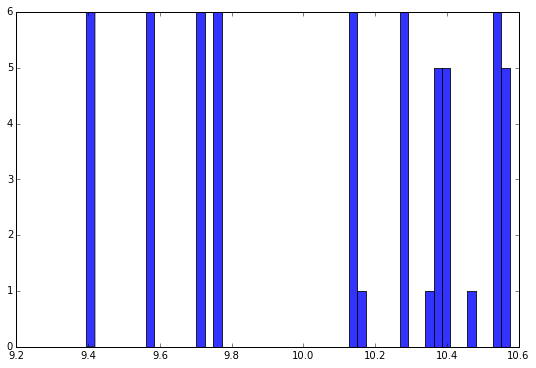

In [67]:
# Do this for all channels, one figure using subplot, each channel with its own subplot
fig4 = plt.figure(4, figsize=(9,6))
numBins = 50
n, bins, patches = plt.hist(channelPeaks[7],numBins,alpha=0.8)

In [ ]:
# plot amp for each channel
#for each channel
    #for each window
        #plot 3d figure with time on horizontal, freqs on vertical, and winAmp as the fluctuating value
for i in range(numOfChannel):
    plt.plot(amp)